# Pre-Run Environment Setup for Google Colab

## Mount Google Drive

In [ ]:
from google.colab import drive

# Mount the drive to access data
drive.mount('/content/drive', force_remount=True)

# Import Libraries

In [ ]:
# Import neccessary libraries
import pandas as pd
import numpy as np

import os
import nibabel as nib
from joblib import dump, load
from tqdm import tqdm
import random
import torch
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Set Seed

In [43]:
# Define a function to set seeds for reproducibility
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# Directory Setup

In [179]:
path_data = "./MnM2/dataset/" # Define path to raw data (uncompressed .nii.gz files)
path_out = './MnM2_preprocessed/' # Define path to save preprocessed outputs (sliced/normalised .nii.gz)

In [180]:
path_images = os.path.join(path_out, 'images') # Define path and create folder for preprocessed image slices
path_rvmasks = os.path.join(path_out, 'rv_masks') # Define path and create folder for right ventricular (RV)-only masks

# Make sure output folders exist
os.makedirs(path_images, exist_ok=True)
os.makedirs(path_rvmasks, exist_ok=True)

# Load Dataset

In [46]:
# Load dataset
df_csv = pd.read_csv('./MnM2/dataset_information.csv', dtype=str)

print("Total number of rows:", len(df_csv))

Total number of rows: 1048574


In [48]:
# Only the first 360 rows have values
df_csv = df_csv.iloc[:360,:]

# Display the dataset
display(df_csv)

,SUBJECT_CODE,DISEASE,VENDOR,SCANNER,FIELD
0,1,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
1,2,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
2,3,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
3,4,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
4,5,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
...,...,...,...,...,...
355,356,TRI,SIEMENS,Symphony,1.5
356,357,TRI,SIEMENS,SymphonyTim,1.5
357,358,TRI,SIEMENS,Symphony,1.5
358,359,TRI,SIEMENS,SymphonyTim,1.5


In [49]:
# Standardise the subject code to three digits, eg. 001, 002,...,360
df_csv['SUBJECT_CODE'] = df_csv['SUBJECT_CODE'].apply(lambda x: str(x).zfill(3))

In [ ]:
# Insert set type: training, validation and testing
df_csv.insert(1, "SET_TYPE", ["Training"]*160 + ["Validation"]*40 + ["Testing"]*160)

In [51]:
display(df_csv)

,SUBJECT_CODE,SET_TYPE,DISEASE,VENDOR,SCANNER,FIELD
0,001,Training,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
1,002,Training,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
2,003,Training,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
3,004,Training,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
4,005,Training,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
...,...,...,...,...,...,...
355,356,Testing,TRI,SIEMENS,Symphony,1.5
356,357,Testing,TRI,SIEMENS,SymphonyTim,1.5
357,358,Testing,TRI,SIEMENS,Symphony,1.5
358,359,Testing,TRI,SIEMENS,SymphonyTim,1.5


# Exploratory Data Analysis

## Disease Distribution

In [52]:
# Count the number of subjects per disease
disease_counts = df_csv['DISEASE'].value_counts().sort_values(ascending=False)

print("Disease distribution:\n", disease_counts)

Disease distribution:
 DISEASE
NOR     75
LV      60
HCM     60
ARR     35
FALL    35
CIA     35
RV      30
TRI     30
Name: count, dtype: int64


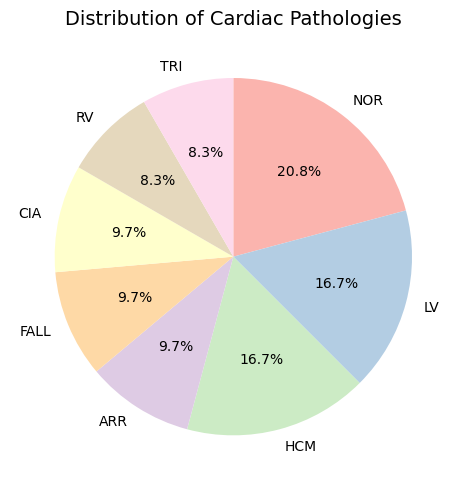

In [10]:
# Plot pie chart of disease distribution
plt.figure(figsize=(5, 5))
colors = plt.cm.Pastel1.colors
disease_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=90,
    counterclock=False,
    colors=colors
)
plt.title('Distribution of Cardiac Pathologies', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

## Choose Pathologies

In [53]:
# Select three pathology types: NOR, LV and HCM (3 highest frequency)
selected_df_csv = df_csv[df_csv["DISEASE"].isin(["NOR", "LV", "HCM"])]

In [61]:
# Group data by set type and disease
sunburst_data = selected_df_csv.groupby(['SET_TYPE', 'DISEASE']).size().reset_index(name='Count')

# Define colour mapping
unique_sets = sunburst_data['SET_TYPE'].unique()
default_colors = px.colors.qualitative.Pastel
color_discrete_map = {set_type: default_colors[i % len(default_colors)] for i, set_type in enumerate(unique_sets)}

# Plot sunburst piechart
fig = px.sunburst(
    sunburst_data,
    path=['SET_TYPE', 'DISEASE'],
    values='Count',
    color='SET_TYPE',
    color_discrete_map=color_discrete_map,
)

# Update trace text
fig.update_traces(textinfo='label+percent entry')

# Update layout
fig.update_layout(
    width=500, # adjust width in pixels
    height=500, # adjust height in pixels
    title_text="Dataset Distribution by Set Type and Disease",
    title_x=0.5
)

fig.show()

## Quality Checking

### Verify Segmentation Masks
Ensure that ground truth masks are present and contain valid label values.

### Check Folder Structure & File Availability
Confirm that each subject folder exists, includes 
- A usable image (SA_ED or SA_ES)
- A corresponding ground truth (_gt) file
- Check for corrupted or unreadable .nii.gz files

In [ ]:
# Get a sorted list of subject folders, eg. 001, 002,..., 360)
subject_folders = sorted(os.listdir(path_data))

In [74]:
# Initialise trackers
missing_folders = [] # Subjects whose folders are missing entirely
missing_images = []  # Subjects missing usable SA_ED or SA_ES image
missing_masks = []   # Subjects missing corresponding ground truth masks
corrupt_files = []   # Subjects with corrupted or unreadable .nii.gz files
label_summary = {}   # Store unique labels found in each subject's mask

# Loop through all subject folders
for subject_id in tqdm(subject_folders):
    subject_path = os.path.join(path_data, subject_id)

    # Check if folder exists
    if not os.path.isdir(subject_path):
        missing_folders.append(subject_id)
        continue

    # List all files in folder
    files = os.listdir(subject_path)

    # Look for a usable image file (Prefer SA_ED, otherwise SA_ES)
    # Exclude ground truth mask files from image selection
    img_file = next((f for f in files if 'SA_ED.nii.gz' in f and 'gt' not in f), None)
    if not img_file:
        img_file = next((f for f in files if 'SA_ES.nii.gz' in f and 'gt' not in f), None)

    if not img_file:
        missing_images.append(subject_id)
        continue

    # Construct expected mask filename, eg. SA_ED.nii.gz -> SA_ED_gt.nii.gz
    gt_file = img_file.replace('.nii.gz', '_gt.nii.gz')
    if gt_file not in files:
        missing_masks.append(subject_id)
        continue

    # Attempt to load image and mask
    # Record corrupted files if loading fails
    try:
        img_path = os.path.join(subject_path, img_file)
        mask_path = os.path.join(subject_path, gt_file)

        _ = nib.load(img_path).get_fdata()     # Load image
        mask = nib.load(mask_path).get_fdata() # Load mask

        # Extract and store unique labels in mask
        unique_labels = np.unique(mask)
        label_summary[subject_id] = unique_labels

    except Exception as e:
        # Record corrupted subject and error message
        corrupt_files.append((subject_id, str(e)))
        continue

# Summarise label combinations
label_combos = [', '.join(map(str, labels)) for labels in label_summary.values()]
combo_counts = Counter(label_combos)

100%|██████████| 360/360 [00:37<00:00,  9.62it/s]


In [75]:
# Print summary
print(f"Missing subject folders: {missing_folders}")
print(f"Subjects missing usable image (SA_ED or SA_ES): {missing_images}")
print(f"Subjects missing ground truth masks: {missing_masks}")

print("\nSubjects with corrupt .nii.gz files:")
for sid, error in corrupt_files:
    print(f" - {sid}: {error}")

print("\nUnique label combinations across subjects:")
for combo, count in combo_counts.items():
    print(f"Labels: [{combo}]: {count} subject(s)")

Missing subject folders: []
Subjects missing usable image (SA_ED or SA_ES): []
Subjects missing ground truth masks: []

Subjects with corrupt .nii.gz files:

Unique label combinations across subjects:
Labels: [0.0, 1.0, 2.0, 3.0]: 360 subject(s)


<br>**The segmentation label mapping is defined as follows:**</br>
0 – Background: Pixels that do not belong to any cardiac structure (non-heart tissue and surrounding areas).

1 – Left Ventricle (LV): Refers to the cavity of the left ventricle, which pumps oxygenated blood to the body.

2 – Myocardium (Myo): Refers to the muscular wall of the heart, specifically between the left and right ventricles.

3 – Right Ventricle (RV): Refers to the cavity of the right ventricle, which pumps deoxygenated blood to the lungs.

## Image Dimension Consistency Check

In [78]:
# Initialise tracker
image_shapes = [] # Store image shapes (height, width, number of slices)

# Loop through subject folders
for subject_id in tqdm(subject_folders):
    subject_path = os.path.join(path_data, subject_id)
    
    # Check if folder exists
    if not os.path.isdir(subject_path):
        continue

    # List all files in folder
    files = os.listdir(subject_path)

    # Try to find SA_ED or SA_ES image (non-gt), SA_ED (preferred)
    img_file = next((f for f in files if 'SA_ED.nii.gz' in f and 'gt' not in f), None)
    
    # If not found, try SA_ES
    if not img_file:
        img_file = next((f for f in files if 'SA_ES.nii.gz' in f and 'gt' not in f), None)
    
    # If no usable image file is found, skip this subject
    if not img_file:
        continue

    # Try loading the image and record its shape
    try:
        img_data = nib.load(os.path.join(subject_path, img_file)).get_fdata()
        image_shapes.append(img_data.shape) # (height, width, slices)
    except:
        continue

# Convert to DataFrame
df_image_shapes = pd.DataFrame(image_shapes, columns=['Height', 'Width', 'Slices'])


100%|██████████| 360/360 [00:13<00:00, 27.63it/s]


In [80]:
# Print summary statistics
print("Summary statistics of image dimensions:")
print(df_image_shapes.describe())

Summary statistics of image dimensions:
           Height       Width      Slices
count  360.000000  360.000000  360.000000
mean   281.455556  262.572222   11.288889
std     68.372511   80.081541    1.858471
min    192.000000  196.000000    6.000000
25%    240.000000  196.000000   10.000000
50%    256.000000  240.000000   11.000000
75%    320.000000  320.000000   12.000000
max    512.000000  512.000000   28.000000


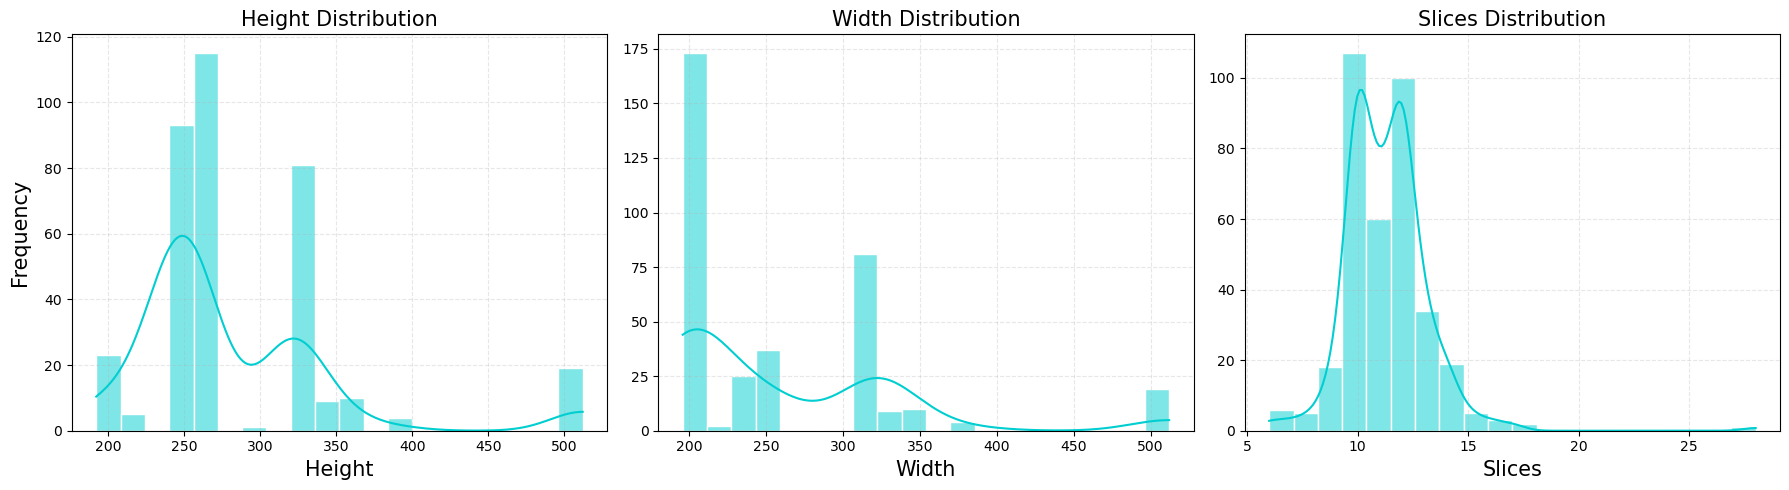

In [119]:
# Plot distribution of each dimension
plt.figure(figsize=(18, 5))

for i, col in enumerate(['Height', 'Width', 'Slices']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_image_shapes[col], kde=True, bins=20, color="darkturquoise", edgecolor="white")
    plt.title(f'{col} Distribution', fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.3)
    if i == 0:
        plt.ylabel('Frequency', fontsize=15)
    else:
        plt.ylabel('')

plt.tight_layout()
plt.show()

## Sample Image and Ground Truth Visualisation

In [172]:
# Define files
subject_id = "001"
cardiac_imaging = "ED" # Choose either "ED" or "ES"

# Map phase abbreviation to full name
phase_map = {"ED": "End-Diastole", "ES": "End-Systole"}
phase_name = phase_map.get(cardiac_imaging, "Unknown Phase")

image_file = f"{subject_id}_SA_{cardiac_imaging}.nii.gz"
mask_file = f"{subject_id}_SA_{cardiac_imaging}_gt.nii.gz"

In [173]:
# Load image and mask
img_path = os.path.join(path_data, subject_id, image_file)
mask_path = os.path.join(path_data, subject_id, mask_file)

img = nib.load(img_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

print(f"Shape of cardiac MRI scan for {subject_id} ({phase_name}):", img.shape) # (height, width, #slices)

Shape of cardiac MRI scan for 001 (End-Diastole): (256, 256, 12)


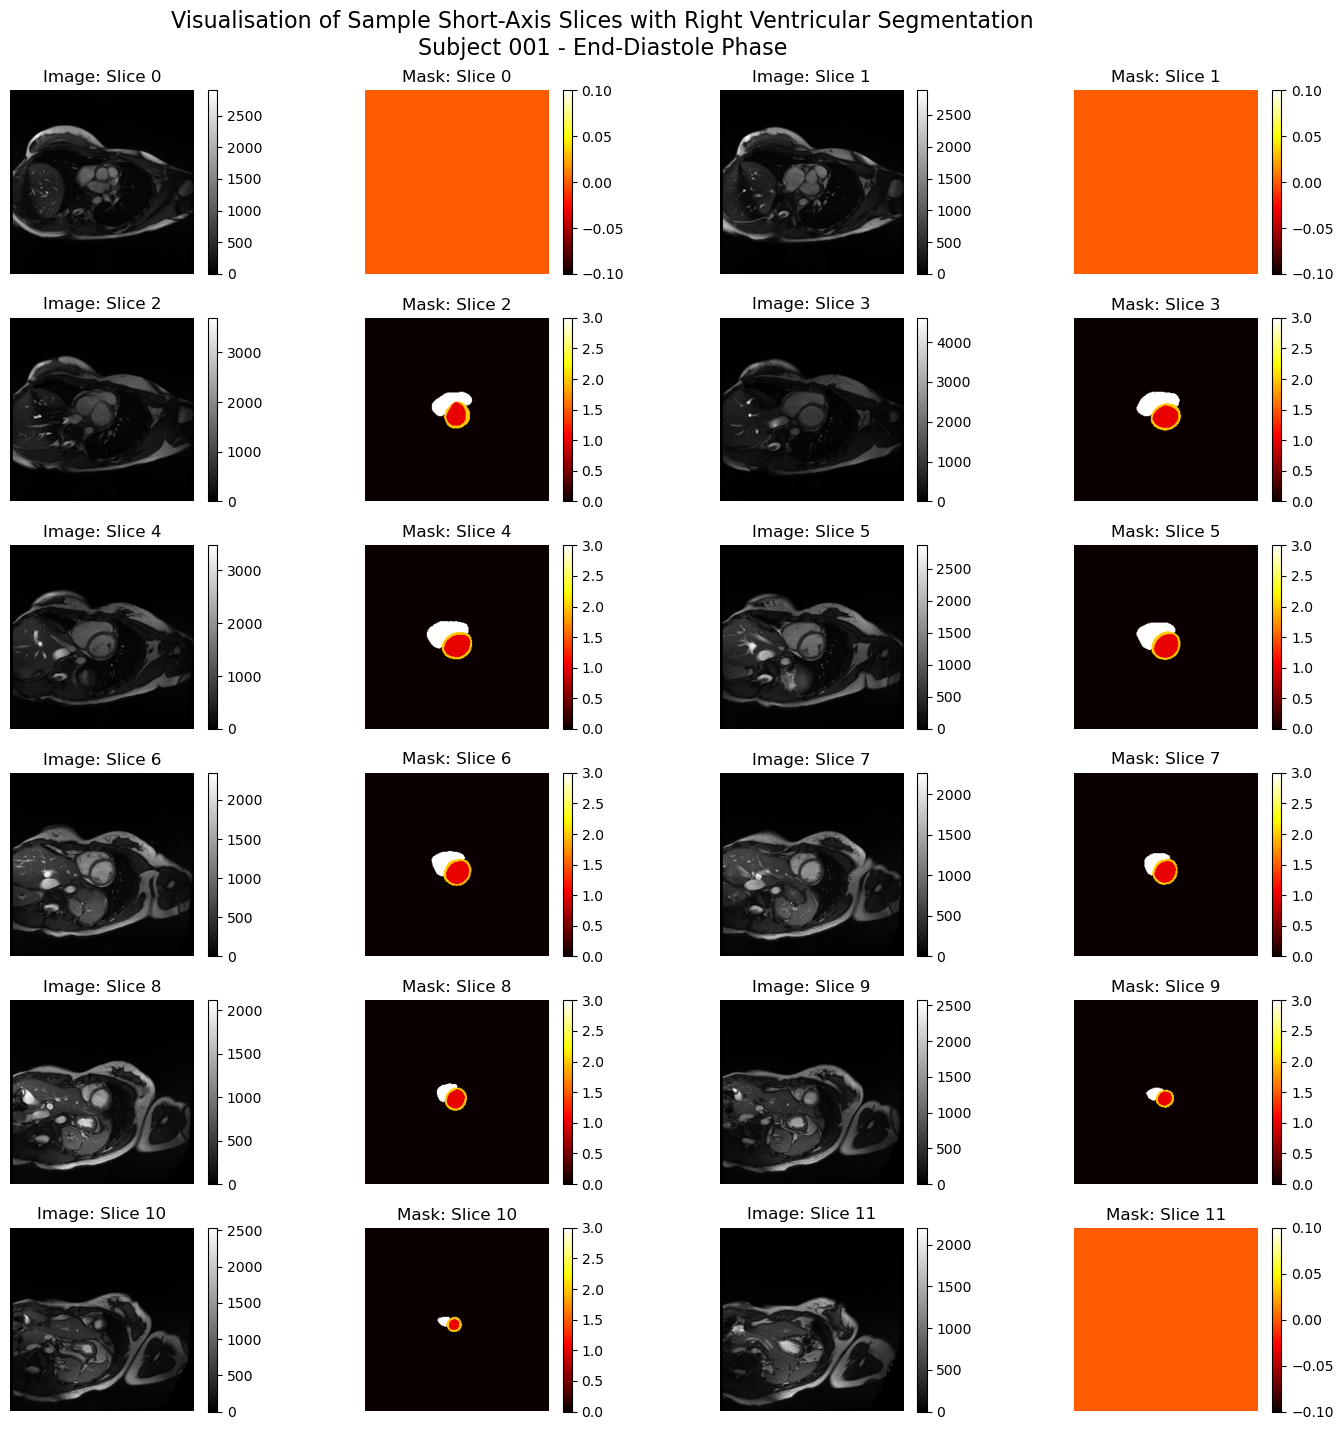

In [174]:
# Visualise image and mask side by side
fig, axs = plt.subplots(6, 4, figsize=(15, 15))

for j in range(img.shape[2]):
    i = j * 2

    # Display MRI slice
    ax_img = axs.flatten()[i]
    im1 = ax_img.imshow(img[:, :, j], cmap='gray')
    ax_img.set_title(f"Image: Slice {j}", fontsize=12)
    ax_img.axis('off')
    plt.colorbar(im1, ax=ax_img, fraction=0.046, pad=0.04)

    # Display corresponding mask
    ax_mask = axs.flatten()[i + 1]
    im2 = ax_mask.imshow(mask[:, :, j], cmap='hot')
    ax_mask.set_title(f"Mask: Slice {j}", fontsize=12)
    ax_mask.axis('off')
    plt.colorbar(im2, ax=ax_mask, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"Visualisation of Sample Short-Axis Slices with Right Ventricular Segmentation\nSubject {subject_id} - {phase_name} Phase", x=0.5, ha='center', fontsize=16)
plt.show()

## Overlay MRI Slice with Segmentation Mask Visualisation

In [175]:
# Define files
normal_subID = "001"
lv_subID = "050"
hcm_subID = "080"

In [176]:
# Define paths and load sample subjects
normal_subID = "001"
lv_subID = "050"
hcm_subID = "080"

sample_vis = {
    "Normal": {
        "img": nib.load(os.path.join(path_data, normal_subID, f"{normal_subID}_SA_{cardiac_imaging}.nii.gz")).get_fdata(),
        "gt": nib.load(os.path.join(path_data, normal_subID, f"{normal_subID}_SA_{cardiac_imaging}_gt.nii.gz")).get_fdata()
    },
    "Dilated Left Ventricle": {
        "img": nib.load(os.path.join(path_data, lv_subID, f"{lv_subID}_SA_{cardiac_imaging}.nii.gz")).get_fdata(),
        "gt": nib.load(os.path.join(path_data, lv_subID, f"{lv_subID}_SA_{cardiac_imaging}_gt.nii.gz")).get_fdata()
    },
    "Hypertrophic Cardiomyopathy": {
        "img": nib.load(os.path.join(path_data, hcm_subID, f"{hcm_subID}_SA_{cardiac_imaging}.nii.gz")).get_fdata(),
        "gt": nib.load(os.path.join(path_data, hcm_subID, f"{hcm_subID}_SA_{cardiac_imaging}_gt.nii.gz")).get_fdata()
    }
}

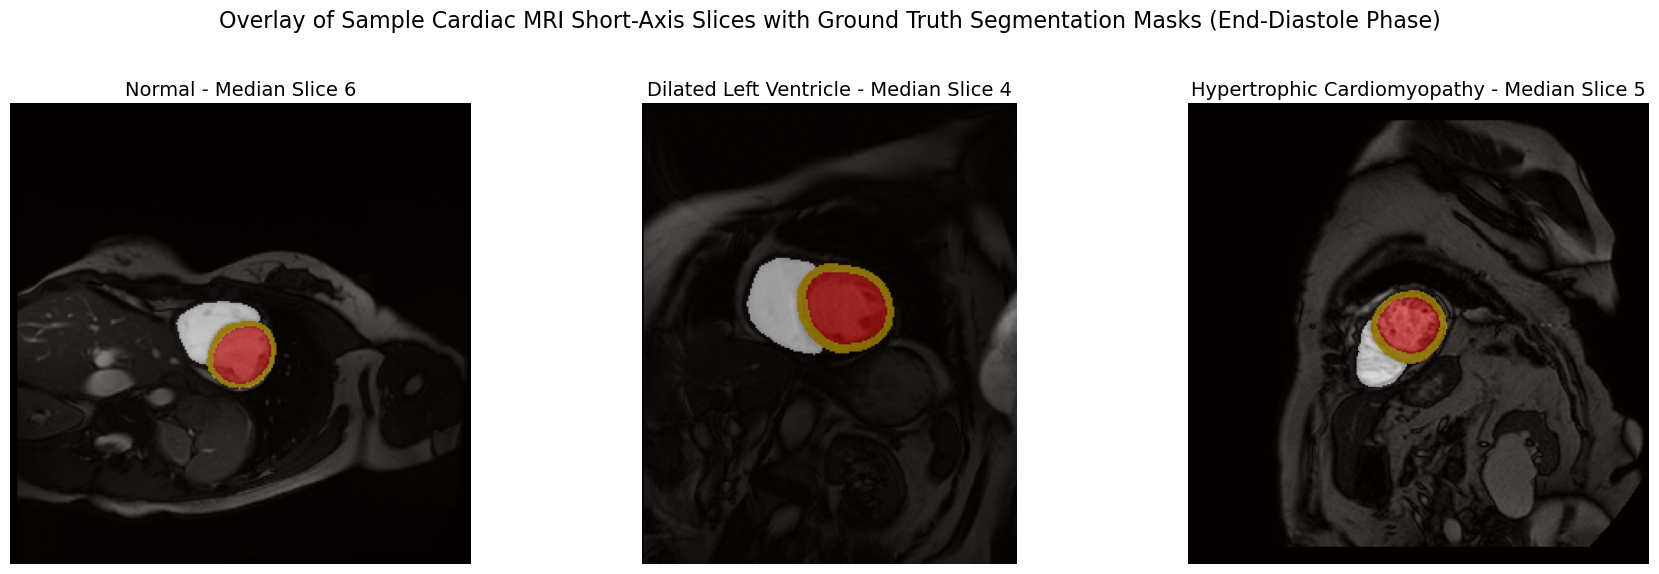

In [178]:
# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (label, data) in enumerate(sample_vis.items()):
    img = data['img']
    gt = data['gt']
    median_slice = img.shape[2] // 2

    ax = axs[i]
    ax.imshow(img[:, :, median_slice], cmap='gray')
    ax.imshow(gt[:, :, median_slice], cmap='hot', alpha=0.5) # Overlay mask
    ax.set_title(f"{label} - Median Slice {median_slice}", fontsize=14)
    ax.axis('off')

plt.suptitle(f"Overlay of Sample Cardiac MRI Short-Axis Slices with Ground Truth Segmentation Masks ({phase_name} Phase)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()